# Линейная классификация

Рассмотрим в работе способы построения линейной модели классификации.

Линейный классификатор представляет собой линейную модель, разделяющую два класса (-1, 1). Линейная модель описывается следующей формулой $\langle \omega, x \rangle + b = y$. Вектор весов $\omega$ - вектор нормали этой линейно модели. При $y = 0$, все точки $x$ принадлежат этой разделяющей прямой, при $y > 0$ объеты $x$ лежат с той стороны прямой линии, куда смотрит вектор весов $\omega$, при $y < 0$ с другой стороны прямой линии. Таким образом линейная модель разделяет все объекты на положительный и отрицательные, причем чем дальше объект лежит от прямой, тем большее абсолютное значение он имеет.

Необходимо ввести обозначение отступа:

$$M = y \langle \omega, x \rangle$$

Таким образом, если объект будет лежать со стороны своего класса (классифицироваться правильно), то $M$ всегда будет иметь положительное значение. В случае неправилной классификации отступ будет отрицательным.

Введем несколько loss-функцию, которые будет оптимизировать:

1. логистическая: $$\bar L(M) = \ln(1+ \exp(-M))$$

2. экспоненциальны: $$\bar L(M) = \exp(-M)$$

3. кусочно-линейная: $$\bar L(M) = max(0, 1-M))$$

Таким образом для каждого объекта будет вычислена его собственный штраф. Чтобы получить полную функцию потеря - просто проссумируем штрафы всех объектов.
Таким образом у нас будет функция, подсчитывающая штрафы для конкретной модели. Необходимо ее оптимизировать, для этого надо вычислить градиент и начать движение (изменение весов модели $\omega$) в сторону антиградиента с некоторым постоянным шагом.

## Задача
1. Написать функцию расчета функции потерь (loss-функции) и градиента функции. (выбрать любую функцию)
2. Реализовать градиентный спуск по всем данным.
3. Реализовать стохастический градиентный спуск.

In [0]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
from sympy import *
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Задача 1
Напишите две функции, которые будут получать на вход вектор весов, признаки и целевую переменную. Функции должны возвращать суммарную ошибку и градиент.

In [0]:
W0, W1, W2, x1, x2, y = symbols('w0 w1 w2 x1 x2 y')
ln_diff_w0 = diff(ln(1 + exp(-(W0 + W1 * x1 + W2 * x2) * y)), W0)
ln_diff_w1 = diff(ln(1 + exp(-(W0 + W1 * x1 + W2 * x2) * y)), W1)
ln_diff_w2 = diff(ln(1 + exp(-(W0 + W1 * x1 + W2 * x2) * y)), W2)
exp_diff_w0 = diff(exp(-(W0 + W1 * x1 + W2 * x2) * y), W0)
exp_diff_w1 = diff(exp(-(W0 + W1 * x1 + W2 * x2) * y), W1)
exp_diff_w2 = diff(exp(-(W0 + W1 * x1 + W2 * x2) * y), W2)

In [3]:
print('Логистическая W0 = {}\nЛогистическая W1 = {}\nЛогистическая W2 = {}\n'.format(ln_diff_w0, ln_diff_w1, ln_diff_w2))
print('Экспоненциальная W0 = {}\nЭкспоненциальная W1 = {}\nЭкспоненциальная W2 = {}\n'.format(exp_diff_w0, exp_diff_w1, exp_diff_w2))

Логистическая W0 = -y*exp(y*(-w0 - w1*x1 - w2*x2))/(exp(y*(-w0 - w1*x1 - w2*x2)) + 1)
Логистическая W1 = -x1*y*exp(y*(-w0 - w1*x1 - w2*x2))/(exp(y*(-w0 - w1*x1 - w2*x2)) + 1)
Логистическая W2 = -x2*y*exp(y*(-w0 - w1*x1 - w2*x2))/(exp(y*(-w0 - w1*x1 - w2*x2)) + 1)

Экспоненциальная W0 = -y*exp(y*(-w0 - w1*x1 - w2*x2))
Экспоненциальная W1 = -x1*y*exp(y*(-w0 - w1*x1 - w2*x2))
Экспоненциальная W2 = -x2*y*exp(y*(-w0 - w1*x1 - w2*x2))



In [0]:
def loss(c_w0, c_w1, c_w2, x, y):
    M = margin(c_w0, c_w1, c_w2, x, y) 
    return np.log(1 + np.exp(-M))

def full_loss(c_w0, c_w1, c_w2, x, y):
    loss_f = 0
    for i in range(len(x)):
        loss_f += loss(c_w0, c_w1, c_w2, x[i], y[i])
    return loss_f

def margin(c_w0, c_w1, c_w2, x, y):
    return y * (c_w0 + c_w1 * x[0] + c_w2 * x[1])

def grad_loss(c_w0, c_w1, c_w2, x, y, param='', loss=''):
    w_loss = 0
    for i in range(len(x)):
        M = margin(c_w0, c_w1, c_w2, x[i], y[i])
        if loss == 'log':
            if param == 'w0': w_loss += (y[i] * -np.exp(-M)) / (np.exp(-M)+1)
            elif param == 'w1': w_loss += (y[i] * -x[i,0] * np.exp(-M)) / (np.exp(-M)+1)
            else: w_loss += (y[i] * -x[i,1] * np.exp(-M)) / (np.exp(-M)+1)
        elif loss == 'exp':
            if param == 'w0': w_loss += (-y[i] * np.exp(-M))
            elif param == 'w1': w_loss += (y[i] * -x[i,0] * np.exp(-M))
            else: w_loss += (y[i] * -x[i,1] * np.exp(-M))
    return w_loss

Дан набор данных.
Проведена нормализация данных по признакам и выставлены классы (-1, 1).

Проведите случайную линейную модель, постройте ее на графике и вычислите для нее суммарную функцию ошибки.
Проверьте, что суммарная функция ошибки считается правильно.

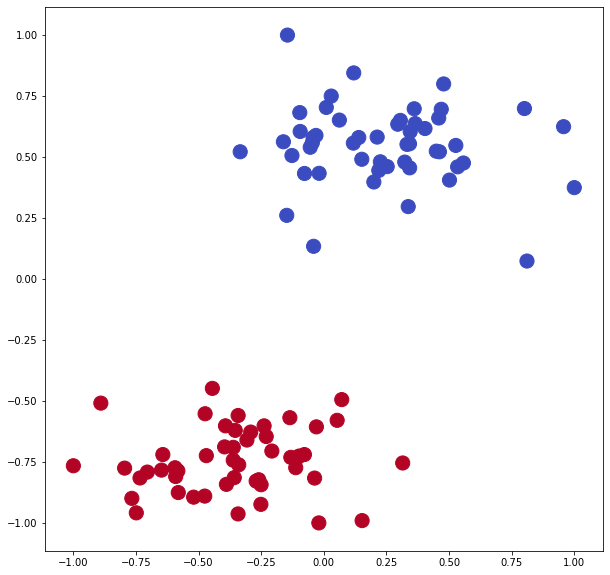

In [5]:
X, Y = make_blobs(n_samples=100, n_features=2, centers=2 ,cluster_std=1, random_state=17, center_box=(-10, 10))
cmap = plt.cm.coolwarm
plt.figure(figsize=(10,10))
X[:,0] = 2 * (X[:,0] - X[:,0].min()) / (X[:,0].max() - X[:,0].min()) - 1
X[:,1] = 2 * (X[:,1] - X[:,1].min()) / (X[:,1].max() - X[:,1].min()) -1 
plt.scatter(X[:,0], X[:,1], s = 200, c = Y, cmap=cmap);
Y[Y == 0] = -1

### Задача 2. Реализация метода градиентного спуска
Постройте анимационную гифку схождения вашей линейной модели к данным. Подпишите loss к каждому кадру на гифке.

Loss для начальных параметров 89.20179032905632
Loss для конечных параметров ln 0.4433109407512388
Loss для конечных параметров exp 0.24823652442982502
Время вычислений градиентного спуска (дважды: для ln и exp)= 5.62885594367981 секунд


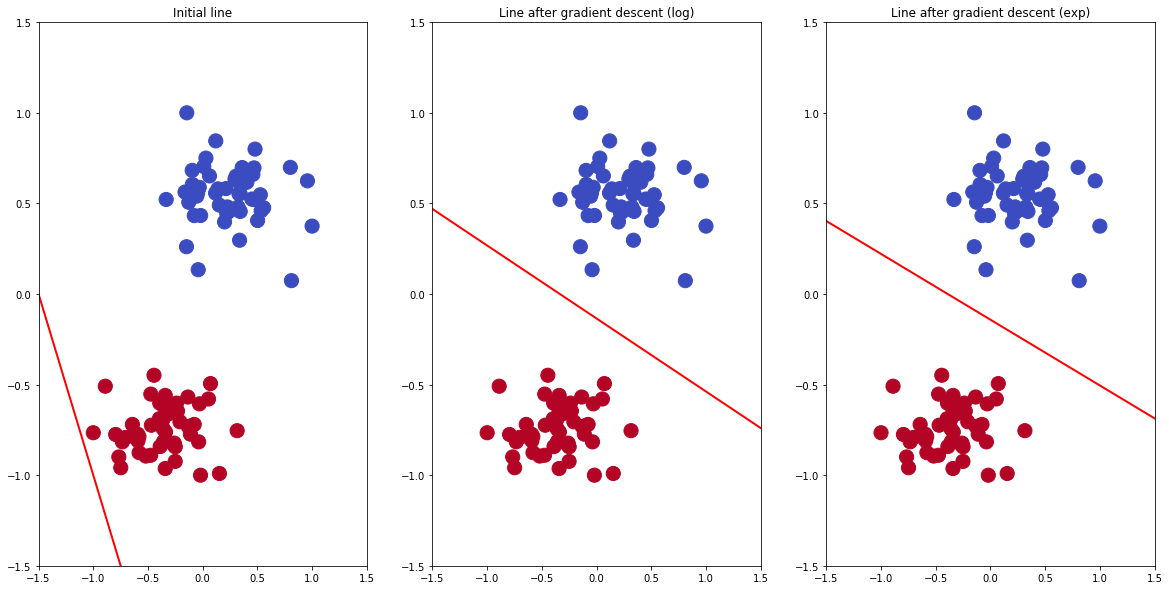

In [6]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import animation, rc
import time

fig, ax = plt.subplots(1,3, figsize=(20,10))
m = 0.01 # шаг обучения

ax[0].scatter(X[:,0], X[:,1], s = 200, c = Y, cmap=cmap)
ax[1].scatter(X[:,0], X[:,1], s = 200, c = Y, cmap=cmap)
ax[2].scatter(X[:,0], X[:,1], s = 200, c = Y, cmap=cmap)
ax[0].set_title('Initial line')
ax[1].set_title('Line after gradient descent (log)')
ax[2].set_title('Line after gradient descent (exp)')

w0, w1, w2 = -3, -2, -1
print('Loss для начальных параметров {}'.format(full_loss(w0, w1, w2, X, Y)))
line = lambda g : -(w0 + w1 * g) / w2
ax[0].plot([X[:,0].min() - .5, X[:,0].max() + .5], [line(X[:,0].min() - .5), line(X[:,0].max() + .5)], 'r-', linewidth=2)

# Настройка графика
ax[0].set_xlim([X[:,0].min() - .5, X[:,0].max() + .5])
ax[0].set_ylim([X[:,1].min() - .5, X[:,1].max() + .5])
ax[1].set_xlim([X[:,0].min() - .5, X[:,0].max() + .5])
ax[1].set_ylim([X[:,1].min() - .5, X[:,1].max() + .5])
ax[2].set_xlim([X[:,0].min() - .5, X[:,0].max() + .5])
ax[2].set_ylim([X[:,1].min() - .5, X[:,1].max() + .5])

def update_params(i, loss=''):
    global w0,w1,w2, X, Y, m
    # update W params
    w0_shift = grad_loss(w0,w1,w2,X,Y, param = 'w0', loss=loss)
    w1_shift = grad_loss(w0,w1,w2,X,Y, param = 'w1', loss=loss)
    w2_shift = grad_loss(w0,w1,w2,X,Y, param = 'w2', loss=loss)
    w0 -= m * w0_shift
    w1 -= m * w1_shift
    w2 -= m * w2_shift
    return w0,w1,w2

start = time.time()

W0_new = 0; W1_new = 0; W2_new = 0
for i in range(1000):
    W0_new, W1_new, W2_new = update_params(i, loss='log')
print('Loss для конечных параметров ln {}'.format(full_loss(W0_new, W1_new, W2_new, X, Y)))
new_line = lambda point : -(W0_new + W1_new * point) / W2_new
ax[1].plot([X[:,0].min() - .5, X[:,0].max() + .5], [new_line(X[:,0].min() - .5), new_line(X[:,0].max() + .5)], 'r-', linewidth=2);

W0_new = 0; W1_new = 0; W2_new = 0
for i in range(1000):
    W0_new, W1_new, W2_new = update_params(i, loss='exp')
print('Loss для конечных параметров exp {}'.format(full_loss(W0_new, W1_new, W2_new, X, Y)))

new_line = lambda point : -(W0_new + W1_new * point) / W2_new
ax[2].plot([X[:,0].min() - .5, X[:,0].max() + .5], [new_line(X[:,0].min() - .5), new_line(X[:,0].max() + .5)], 'r-', linewidth=2);

end = time.time()
print(f'Время вычислений градиентного спуска (дважды: для ln и exp)= {end-start} секунд')

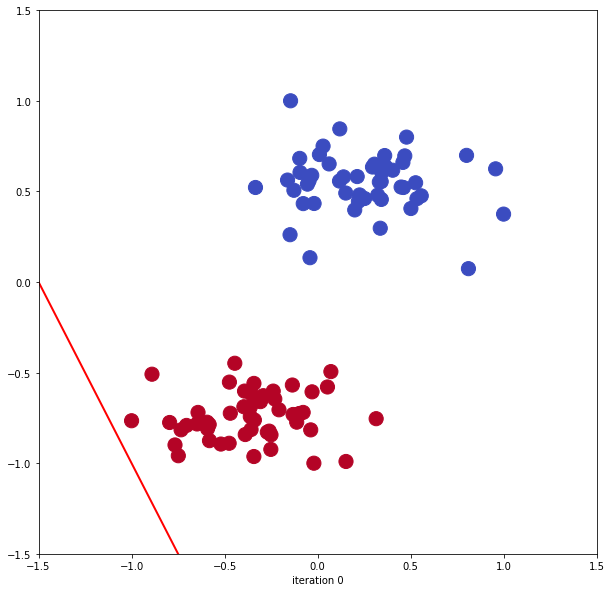

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
m = 0.1 # шаг обучения
plt.scatter(X[:,0], X[:,1], s = 200, c = Y, cmap=cmap)

w0, w1, w2 = -3, -2, -1
line = lambda point : -(w0 + w1 * point) / w2
clf, = ax.plot([X[:,0].min() - .5, X[:,0].max() + .5], [line(X[:,0].min() - .5), line(X[:,0].max() + .5)], 'r-', linewidth=2)

ax.set_xlim([X[:,0].min() - .5, X[:,0].max() + .5])
ax.set_ylim([X[:,1].min() - .5, X[:,1].max() + .5])

def update_plot(i):
    global w0,w1,w2, X, Y, m
    label = 'iteration {0}'.format(i)
    if i == 0:
        line = lambda point : -(w0 + w1 * point) / w2
        clf.set_ydata([line(X[:,0].min() - .5), line(X[:,0].max() + .5)])
        ax.set_xlabel(label)
        return line, ax
    # update W params
    w0_shift = grad_loss(w0,w1,w2,X,Y, param = 'w0', loss='log')
    w1_shift = grad_loss(w0,w1,w2,X,Y, param = 'w1', loss='log')
    w2_shift = grad_loss(w0,w1,w2,X,Y, param = 'w2', loss='log')
    w0 -= m * w0_shift
    w1 -= m * w1_shift
    w2 -= m * w2_shift
    line = lambda x : -(w0 + w1 * x) / w2
    clf.set_ydata([line(X[:,0].min()), line(X[:,0].max())])
    ax.set_xlabel(label)
    return line, ax

anim = FuncAnimation(fig, update_plot, frames=np.arange(0, 100));
rc('animation', html='html5');

In [8]:
print(W0_new, W1_new, W2_new)

-1.453314071325198 -3.718965862097129 -10.245335797912302


In [9]:
anim

### Задача 3. Реализация стохастического градиентного спуска.
Используйте на каждой итерации не весь набор данных, а $n$ случайных объектов из выборки. Оформите результат схождения вашей модели в виде гифки.

Loss для начальных параметров 89.20179032905632
Loss для конечных параметров ln 1.6314371241426626
Loss для конечных параметров exp 0.913943964383373
Время вычислений стохастического градиентного спуска (дважды: для ln и exp) = 1.442458152770996 секунд


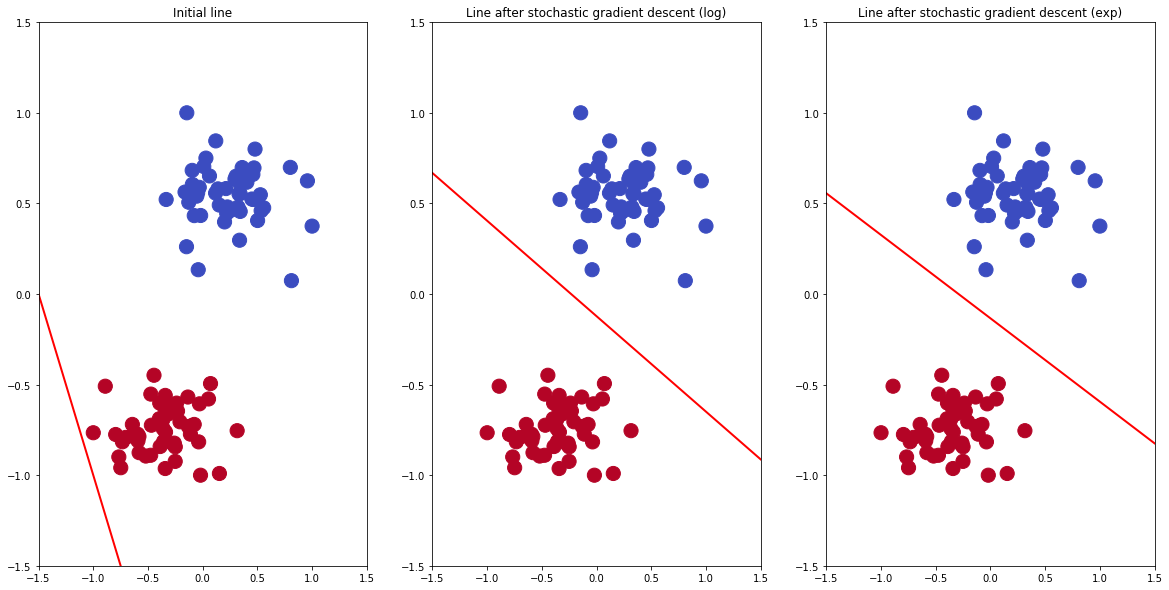

In [10]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import animation, rc
import random

fig, ax = plt.subplots(1,3, figsize=(20,10))
m = 0.01 # шаг обучения

ax[0].scatter(X[:,0], X[:,1], s = 200, c = Y, cmap=cmap)
ax[1].scatter(X[:,0], X[:,1], s = 200, c = Y, cmap=cmap)
ax[2].scatter(X[:,0], X[:,1], s = 200, c = Y, cmap=cmap)
ax[0].set_title('Initial line')
ax[1].set_title('Line after stochastic gradient descent (log)')
ax[2].set_title('Line after stochastic gradient descent (exp)')

w0, w1, w2 = -3, -2, -1
print('Loss для начальных параметров {}'.format(full_loss(w0, w1, w2, X, Y)))
line = lambda g : -(w0 + w1 * g) / w2
ax[0].plot([X[:,0].min() - .5, X[:,0].max() + .5], [line(X[:,0].min() - .5), line(X[:,0].max() + .5)], 'r-', linewidth=2)

# Настройка графика
ax[0].set_xlim([X[:,0].min() - .5, X[:,0].max() + .5])
ax[0].set_ylim([X[:,1].min() - .5, X[:,1].max() + .5])
ax[1].set_xlim([X[:,0].min() - .5, X[:,0].max() + .5])
ax[1].set_ylim([X[:,1].min() - .5, X[:,1].max() + .5])
ax[2].set_xlim([X[:,0].min() - .5, X[:,0].max() + .5])
ax[2].set_ylim([X[:,1].min() - .5, X[:,1].max() + .5])

def update_params(i, loss=''):
    global w0,w1,w2, X, Y, m
    # update W params
    rand_list_int = random.sample(range(0,len(X)-1), int(len(X)/5))
    w0_shift = grad_loss(w0,w1,w2,X[rand_list_int],Y[rand_list_int], param = 'w0', loss=loss)
    w1_shift = grad_loss(w0,w1,w2,X[rand_list_int],Y[rand_list_int], param = 'w1', loss=loss)
    w2_shift = grad_loss(w0,w1,w2,X[rand_list_int],Y[rand_list_int], param = 'w2', loss=loss)
    w0 -= m * w0_shift
    w1 -= m * w1_shift
    w2 -= m * w2_shift
    return w0,w1,w2

start = time.time()
W0_new = 0; W1_new = 0; W2_new = 0
for i in range(1000):
    W0_new, W1_new, W2_new = update_params(i, loss='log')
print('Loss для конечных параметров ln {}'.format(full_loss(W0_new, W1_new, W2_new, X, Y)))
new_line = lambda point : -(W0_new + W1_new * point) / W2_new
ax[1].plot([X[:,0].min() - .5, X[:,0].max() + .5], [new_line(X[:,0].min() - .5), new_line(X[:,0].max() + .5)], 'r-', linewidth=2);

W0_new = 0; W1_new = 0; W2_new = 0
for i in range(1000):
    W0_new, W1_new, W2_new = update_params(i, loss='exp')
print('Loss для конечных параметров exp {}'.format(full_loss(W0_new, W1_new, W2_new, X, Y)))

new_line = lambda point : -(W0_new + W1_new * point) / W2_new
ax[2].plot([X[:,0].min() - .5, X[:,0].max() + .5], [new_line(X[:,0].min() - .5), new_line(X[:,0].max() + .5)], 'r-', linewidth=2);
end = time.time()

print(f'Время вычислений стохастического градиентного спуска (дважды: для ln и exp) = {end-start} секунд')

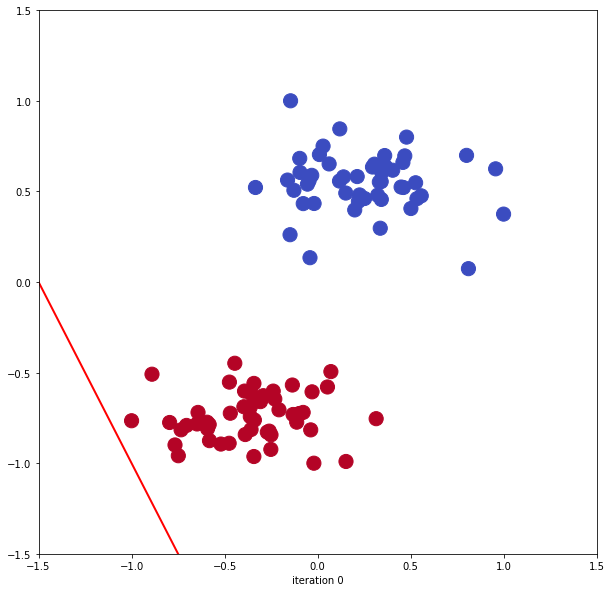

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
m = 0.1 # шаг обучения
plt.scatter(X[:,0], X[:,1], s = 200, c = Y, cmap=cmap)

w0, w1, w2 = -3, -2, -1
line = lambda point : -(w0 + w1 * point) / w2
clf, = ax.plot([X[:,0].min() - .5, X[:,0].max() + .5], [line(X[:,0].min() - .5), line(X[:,0].max() + .5)], 'r-', linewidth=2)

ax.set_xlim([X[:,0].min() - .5, X[:,0].max() + .5])
ax.set_ylim([X[:,1].min() - .5, X[:,1].max() + .5])

def update_plot(i):
    global w0,w1,w2, X, Y, m
    label = 'iteration {0}'.format(i)
    if i == 0:
        line = lambda point : -(w0 + w1 * point) / w2
        clf.set_ydata([line(X[:,0].min() - .5), line(X[:,0].max() + .5)])
        ax.set_xlabel(label)
        return line, ax
    # update W params
    w0_shift = grad_loss(w0,w1,w2,X,Y, param = 'w0', loss='log')
    w1_shift = grad_loss(w0,w1,w2,X,Y, param = 'w1', loss='log')
    w2_shift = grad_loss(w0,w1,w2,X,Y, param = 'w2', loss='log')
    w0 -= m * w0_shift
    w1 -= m * w1_shift
    w2 -= m * w2_shift
    line = lambda x : -(w0 + w1 * x) / w2
    clf.set_ydata([line(X[:,0].min()), line(X[:,0].max())])
    ax.set_xlabel(label)
    return line, ax

anim = FuncAnimation(fig, update_plot, frames=np.arange(0, 100));
rc('animation', html='html5');

In [12]:
anim